In [ ]:
# import cv2
# import numpy as np

# # Charger l'image
# image = cv2.imread('/Users/souchaud/Desktop/A_analyser/CytoOne_HL5_10x/2023_12_07_ASMOT110_AX3_P0_x10_15x_CytoOne_HL5/mosaic/mosaic_total_0.tif', cv2.IMREAD_GRAYSCALE)

# # Prétraitement
# blurred = cv2.GaussianBlur(image, (3, 3), 0)
# binary = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
#                                cv2.THRESH_BINARY, 11, 2)

# equalized = cv2.equalizeHist(blurred)

# # Segmentation
# _, binary = cv2.threshold(equalized, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# # Nettoyage
# kernel = np.ones((2,2), np.uint8)  # Plus petit noyau pour opérations morphologiques
# opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
# # Détection des contours
# contours, _ = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# # Filtrage et analyse (exemple)
# for contour in contours:
#     area = cv2.contourArea(contour)
#     if 20 < area < 200:  # Ajustez ces valeurs selon la taille des objets que vous souhaitez conserver
#         cv2.drawContours(image, [contour], -1, (0,255,0), 2)

# # Affichage ou sauvegarde des résultats
# cv2.imshow('Cellules détectées', image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

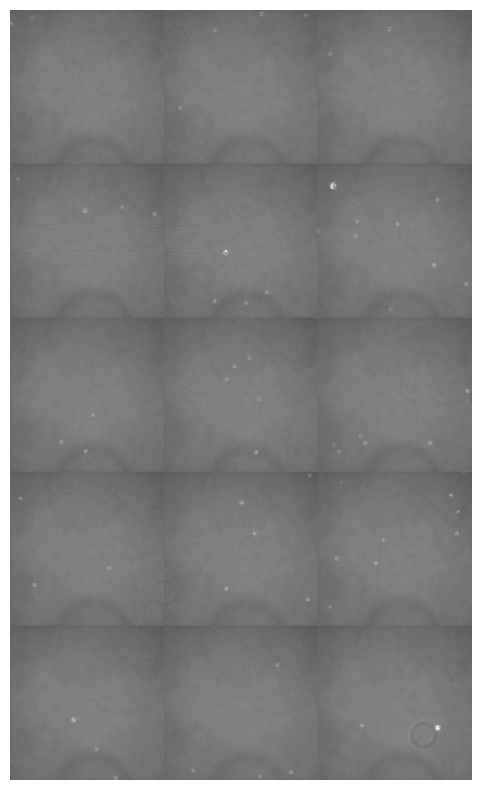

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import util
import trackpy as tp

# Charger l'image
image = cv2.imread('/Users/souchaud/Desktop/A_analyser/CytoOne_HL5_10x/2024_01_31_ASMOT117_AX3_Chi1_P3_10x_CytoOne_HL5/mosaic/mosaic_total_0.tif', cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(10, 10))
plt.imshow(image, cmap='gray')  # cmap='gray' assure que l'image BGR est convertie correctement en nuances de gris pour l'affichage
plt.axis('off')  # Désactiver les axes pour une meilleure visibilité
plt.show()


In [11]:
# Consolidated parameters
PARAMS = {
        # Préparation images
        'GaussianBlur': (31, 31), # (19, 19), #  (5, 5),
        'sigmaX': 10,
        'sigmaY': 10, 
        'threshold': 1, # 3, # 10  # 40,
        'percentile': 1, #10,
        'lenght_study': 50, # Découpage de la manip en nombre de frale pour favoriser l'étude (performence ordi)
        'smoothing_size': None,
        'invert': True,
        'preprocess': True, 
        'characterize': True,
        'filter_before': None,
        'filter_after': None,
        # Paramètres Manip
        'pixel_size': 0.637,  # 1.2773, # en um
        'frame_interval': 15, # temps entre chaque frame
        'long_time': False,
        'max_frame': 340, # 340, #340 # Nombre de frame d'étude max.
        'min_frames': 150, #150, # Nombre de frame sur laquelle doit être suivie une cellule
        'topn': 120, # None, # Nombre de particules max à détecter

        # Détéction particules
        'diameter': 65,  # 15, # Diamètres évalué des particules
        'max_displacement': 30, # 35, # 25, # Déplacement maximal des cellules entre deux images (en pixel)
        'search_range': 30, #  30, #  20 # même chose
        'minmass': 5000, #  Mass minimale mesurée des cellules
        'max_size': 30, # 25, # Taille maximum de la particule
        'separation': 100, # 9, # distance mimimanl pour séparé deux objets
        'noise_size': 15,  # 7, # 7, # taille des particules à exclure 
        'max_iterations': 15, # Nombre d'itérations max pour résoudre un sous-réseau (déterminer les trajectoires entre 2 cellules)
        'memory': 15, # Nombre de frame au dela de laquelle on oublie la cellule
        'engine': 'auto',

        # Format et chemins
        'remove_exts': ['.jpg', '.svg', 'hdf5', '.png'],   
        'data_dir': '/Users/souchaud/Desktop/A_Analyser/CytoOne_HL5_10x/',
        # 'data_dir': '/Volumes/Labo_Alex_Mac/A_analyser/CytoOne_HL5/',
        # 'data_dir': '/Users/souchaud/Desktop/A_Analyser/NonT_SorC/',
        # 'output_dir': '/Users/souchaud/Desktop/Analyses/CytoOne_HL5_longtime/'
        # 'data_dir': '/Volumes/Labo_Alex_Mac/A_analyser/CytoOne_HL5/',´
        'output_dir': '/Users/souchaud/Desktop/Analyses/CytoOne_HL5_10x_new_param/'
        # 'output_dir': '/Users/souchaud/Desktop/Analyses/NonT_SorC_longtime_New/'
        }

In [12]:
# Prétraitement
blurred = ndimage.median_filter(image, size=8)
blurred = cv2.GaussianBlur(blurred, (5, 5), 0)
# equalized = cv2.equalizeHist(blurred)
frame = util.invert(blurred)

62


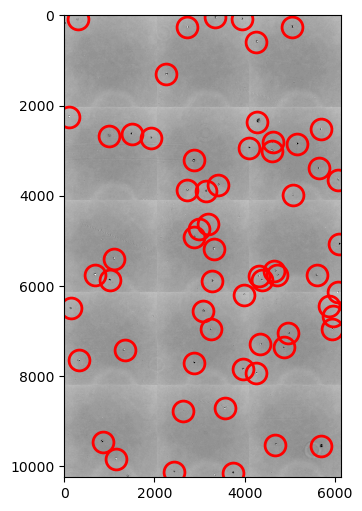

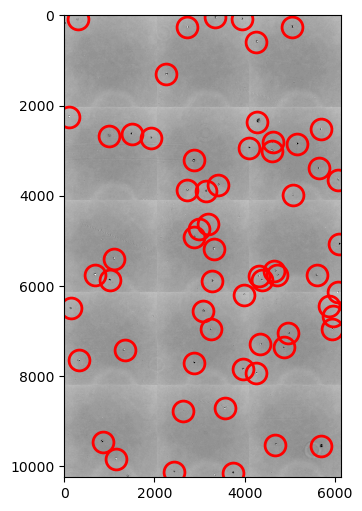

In [13]:
# # Create a CLAHE object (Arguments are optional)
# clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(10, 10))
# # Apply CLAHE
# frame = clahe.apply(frame)
diam = 55
for percentile in [5]: 
    f = tp.locate(frame,
                diameter=diam,
                minmass=1000,
                maxsize=50,
                separation=100,
                noise_size=3,
                smoothing_size=None,
                threshold=10, # 20,
                invert=True,
                percentile=10,
                topn=120,
                preprocess=PARAMS['preprocess'],
                max_iterations=PARAMS['max_iterations'],
                filter_before=PARAMS['filter_before'],
                filter_after=PARAMS['filter_after'],
                characterize=PARAMS['characterize'],
                engine=PARAMS['engine'])
    print(len(f))

    fig, ax = plt.subplots(figsize=(12, 6))
    tp.annotate(f, frame, ax=ax)
    display(fig)


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

def get_top_x_percent_luminous_pixels(image_path, percentile):
    # Charger l'image en grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    ndimage.median_filter(image, size=5)

    # Calculer le seuil correspondant au percentile donné
    # np.percentile retourne la valeur sous laquelle un certain pourcentage des valeurs tombe
    threshold = np.percentile(blurred, 100 - percentile)
    
    # Créer un masque binaire : 1 pour les pixels >= seuil, 0 sinon
    mask = image >= threshold
    
    # Appliquer le masque sur l'image : conserver les pixels originaux où le masque est vrai
    result = np.zeros_like(image)
    result[mask] = image[mask]

    
    return result

# Usage
image_path='/Users/souchaud/Desktop/A_analyser/CytoOne_HL5_10x/2024_01_31_ASMOT120_AX3_Chi1_P3_10x_CytoOne_HL5/mosaic/mosaic_total_0.tif'

percentile = 0.05  # Exemple : récupérer les 5% les plus lumineux
result_image = get_top_x_percent_luminous_pixels(image_path, percentile)

# Afficher ou sauvegarder le résultat
plt.figure(figsize=(10, 10))
plt.imshow(result_image, cmap='gray')  # cmap='gray' assure que l'image BGR est convertie correctement en nuances de gris pour l'affichage
plt.axis('off')  # Désactiver les axes pour une meilleure visibilité
plt.show()

In [ ]:

# Segmentation
_, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Nettoyage
kernel = np.ones((2,2), np.uint8)  # Plus petit noyau pour opérations morphologiques
opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

# Détection des contours
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Création d'une copie de l'image pour dessiner les contours
image_contours = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)  # Convertir en BGR pour dessiner des contours en couleur

# Filtrage et analyse (exemple)
for contour in contours:
    area = cv2.contourArea(contour)
    if 20 < area < 200:  # Ajustez ces valeurs selon la taille des objets que vous souhaitez conserver
        cv2.drawContours(binary, [contour], -1, (0, 255, 0), 2)

# Utiliser matplotlib pour afficher l'image
plt.figure(figsize=(10, 10))
plt.imshow(binary, cmap='gray')  # cmap='gray' assure que l'image BGR est convertie correctement en nuances de gris pour l'affichage
plt.axis('off')  # Désactiver les axes pour une meilleure visibilité
plt.show()
